In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)

In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
test_dataset = torchvision.datasets.FashionMNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)

In [7]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print('number of classes: ', K)

number of classes:  10


In [16]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.shape[0], -1)   # [] yoki ()
        out = self.dense_layers(out)
        return out

In [17]:
# Instantiate the model
model = CNN(K)

In [18]:
# The same model, but with 'Flatten'ing
#model = nn.Sequential(
#    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#    nn.ReLU(),
#    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#    nn.ReLU(),
#    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#    nn.ReLU(),
#    nn.Flatten(),
#    nn.Dropout(0.2),
#    nn.Linear(128*2*2, 512),
#    nn.ReLU(),
#    nn.Dropout(0.2),
#    nn.Linear(512, K)
#)

In [19]:
device = torch.device('cuda:0')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
# Data loader
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, \ Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [38]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.0000, \ Test Loss: 0.1351, Duration: 0:00:59.468509
Epoch 2/15, Train Loss: 0.0000, \ Test Loss: 0.1356, Duration: 0:01:13.085349
Epoch 3/15, Train Loss: 0.0000, \ Test Loss: 0.1276, Duration: 0:01:18.319943
Epoch 4/15, Train Loss: 0.0000, \ Test Loss: 0.1076, Duration: 0:01:05.147245
Epoch 5/15, Train Loss: 0.0000, \ Test Loss: 0.1155, Duration: 0:01:07.476939
Epoch 6/15, Train Loss: 0.0000, \ Test Loss: 0.1018, Duration: 0:01:00.645290
Epoch 7/15, Train Loss: 0.0000, \ Test Loss: 0.1016, Duration: 0:00:29.584619
Epoch 8/15, Train Loss: 0.0000, \ Test Loss: 0.0913, Duration: 0:00:27.555275
Epoch 9/15, Train Loss: 0.0000, \ Test Loss: 0.0873, Duration: 0:00:32.266664
Epoch 10/15, Train Loss: 0.0000, \ Test Loss: 0.0879, Duration: 0:00:29.927968
Epoch 11/15, Train Loss: 0.0000, \ Test Loss: 0.0820, Duration: 0:00:30.970108
Epoch 12/15, Train Loss: 0.0000, \ Test Loss: 0.0790, Duration: 0:00:31.548590
Epoch 13/15, Train Loss: 0.0000, \ Test Loss: 0.0746, Duratio

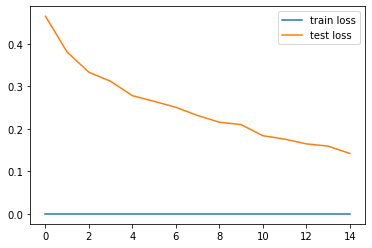

In [24]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [28]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

Train accuracy: 0.9473, Test accuracy: 0.8963


In [31]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix is Normalized')
    else:
        print('Confusion Matrix was normalized before')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Confusion Matrix was normalized before
[[872   0  19  11   4   1  91   0   2   0]
 [  6 975   0  12   3   0   3   0   1   0]
 [ 21   0 827  13  69   0  68   0   2   0]
 [ 24  11  19 877  35   1  33   0   0   0]
 [  3   1  38  22 861   0  71   0   4   0]
 [  1   0   0   1   0 957   0  16   3  22]
 [113   1  55  15 117   0 690   0   9   0]
 [  0   0   0   0   0  11   0 955   0  34]
 [  7   1   5   2   2   3   4   3 973   0]
 [  1   0   0   0   0   3   0  44   0 952]]


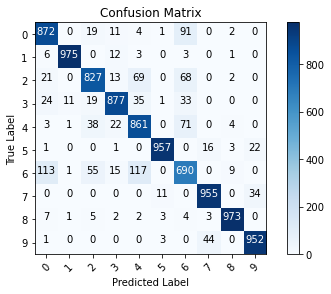

In [33]:
# get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [34]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split('\n')

Text(0.5, 1.0, 'True Label:         Dress  Predicted:         Coat')

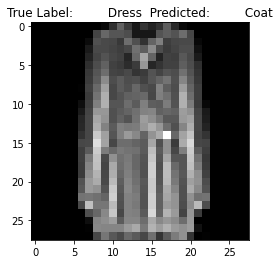

In [37]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title('True Label: %s  Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))